<a href="https://colab.research.google.com/github/AlexsandroAmaro/nlp-perfumery-reviews-case-study/blob/main/Projeto_satisfa%C3%A7%C3%A3o_do_cliente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Motivação

Análise de Sentimento: O Mistério da Categoria "Perfumaria"
Objetivo: Por que a categoria Perfumaria não está performando bem?
O ponto de partida desta análise foi uma suspeita: a categoria "Perfumaria", apesar de estratégica, não estava com uma performance clara e havia ruídos sobre a satisfação dos clientes.

O objetivo foi mergulhar nos dados de feedback dos usuários para responder a duas perguntas centrais:

Qual é o sentimento geral (positivo, negativo ou neutro) dos clientes em relação a essa categoria?

Quais são os principais pontos de reclamação que estão prejudicando a performance?

In [ ]:
pip install leia-br

# Importação das Bibliotecas

In [ ]:
import nltk
nltk.download('stopwords')
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from LeIA import SentimentIntensityAnalyzer

#Leitura de Arquivo

In [ ]:
df_reviews = pd.read_csv(r"/content/sample_data/olist_order_reviews_dataset.csv.zip")
df_entregas = pd.read_csv(r"/content/sample_data/olist_order_items_dataset.csv.zip")
df_produtos = pd.read_csv(r"/content/sample_data/olist_products_dataset.csv.zip")

Os dados necessários estavam divididos em três fontes distintas:

Dataset de Produtos: Informava as categorias (onde encontrar "perfumaria").

Dataset de Pedidos (Orders): Tinha o product_id e o order_id, ligando produtos a pedidos.

Dataset de Reviews: Continha o order_id e o texto do feedback do cliente.

In [ ]:
df_reviews.head(3)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24


In [ ]:
df_entregas.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [ ]:
df_produtos.head(3)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


O problema: não havia ligação direta entre Produtos e Reviews. Para conectar o feedback de um cliente a um produto de perfumaria, foi preciso um processo de merge em duas etapas

#Manipulação dos Dados

> Adicionar aspas



In [ ]:
df_produtos_filtered = df_produtos[df_produtos['product_category_name']=='perfumaria']
df_produtos_filtered['product_category_name']

,product_category_name
0,perfumaria
16,perfumaria
77,perfumaria
84,perfumaria
120,perfumaria
...,...
32710,perfumaria
32744,perfumaria
32780,perfumaria
32919,perfumaria


In [ ]:
df_produtos_filtered = df_produtos_filtered.drop(columns=['product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'])
df_produtos_filtered.head()

,product_id,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria
16,6a2fb4dd53d2cdb88e0432f1284a004c,perfumaria
77,0d009643171aee696f4733340bc2fdd0,perfumaria
84,b1eae565a61935e0011ee7682fef9dc9,perfumaria
120,8da90b37f0fb171b4877c124f965b1f6,perfumaria


In [ ]:
df_produtos_filtered.shape

(868, 2)

Merge 1: Produtos + Pedidos (usando product_id). Isso nos permitiu "etiquetar" todos os pedidos que continham itens de perfumaria.

In [ ]:
df_entregas_perfumaria = pd.merge(left=df_entregas, right=df_produtos_filtered, how='inner', on='product_id')
df_entregas_perfumaria.head()


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name
0,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria
1,000aed2e25dbad2f9ddb70584c5a2ded,1,4fa33915031a8cde03dd0d3e8fb27f01,fe2032dab1a61af8794248c8196565c9,2018-05-16 20:57:03,144.00,8.77,perfumaria
2,002955b0acc63d04f6724a31967e82bd,1,d9bdf643d95cb89844c0da1a0df1d16e,058fd0aa2bfdb2274e05e1ae971dabb6,2017-12-22 15:51:31,120.00,15.59,perfumaria
3,002d040018d12a3853c059f7f23ab5b1,1,97c58626cc3e15d514d2095f69650220,fe2032dab1a61af8794248c8196565c9,2017-11-27 03:47:23,155.00,14.84,perfumaria
4,003822434f91204da0a51fe4cf2aba18,1,99e71b776debf2f01a69dce207e3e4f8,c54679b132454625907c773d273d4126,2018-06-21 02:30:28,69.00,18.58,perfumaria


In [ ]:
df_entregas.shape

(112650, 7)

In [ ]:
df_entregas_perfumaria.shape

(3419, 8)

In [ ]:
df_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


Merge 2: (Resultado do Merge 1) + Reviews (usando order_id).

In [ ]:
df_reviews_perfumaria = pd.merge(left=df_entregas_perfumaria, right=df_reviews, how='inner', on='order_id')
df_reviews_perfumaria.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,f4028d019cb58564807486a6aaf33817,4,NaN,NaN,2018-08-15 00:00:00,2018-08-15 16:39:01
1,000aed2e25dbad2f9ddb70584c5a2ded,1,4fa33915031a8cde03dd0d3e8fb27f01,fe2032dab1a61af8794248c8196565c9,2018-05-16 20:57:03,144.00,8.77,perfumaria,00800678dcf28b0ea0caef2147b6945d,1,produto não entregue,Mudo minha opinião assim que receber o produto...,2018-05-19 00:00:00,2018-05-22 10:52:24
2,002955b0acc63d04f6724a31967e82bd,1,d9bdf643d95cb89844c0da1a0df1d16e,058fd0aa2bfdb2274e05e1ae971dabb6,2017-12-22 15:51:31,120.00,15.59,perfumaria,ba0252394ceecca6d0e9803d75182eb5,5,NaN,NaN,2017-12-27 00:00:00,2018-01-02 13:37:52
3,002d040018d12a3853c059f7f23ab5b1,1,97c58626cc3e15d514d2095f69650220,fe2032dab1a61af8794248c8196565c9,2017-11-27 03:47:23,155.00,14.84,perfumaria,3174be472473a1a73da9880380e7f740,3,NaN,NaN,2017-11-28 00:00:00,2017-11-30 19:44:06
4,003822434f91204da0a51fe4cf2aba18,1,99e71b776debf2f01a69dce207e3e4f8,c54679b132454625907c773d273d4126,2018-06-21 02:30:28,69.00,18.58,perfumaria,7750f9537fc21016d9392ef19661e745,5,NaN,NaN,2018-06-20 00:00:00,2018-06-20 17:35:34


In [ ]:
df_reviews.shape

(99224, 7)

In [ ]:
df_reviews_perfumaria.shape

(3421, 14)

In [ ]:
df_reviews['order_id'].duplicated().any()

np.True_

#Limpeza dos dados

Com o dataset montado, foi iniciada a etapa de tratamento. Além de remover valores nulos que não seriam úteis, foi identificado um problema crítico que poderia distorcer toda a análise: comentários duplicados.

In [ ]:
# keep=False mostra todas as ocorrências de uma duplicata (não apenas a segunda, terceira, etc.)
duplicatas_review = df_reviews_perfumaria[df_reviews_perfumaria.duplicated(subset=['review_id'], keep=False)]

print(duplicatas_review.sort_values('review_id'))

                              order_id  order_item_id  \
1745  7fe6658f268e76d4af99ffc4e5d47541              1   
1746  7fe6658f268e76d4af99ffc4e5d47541              2   
613   2cc44017e7eba3d4a59e029af9df7e31              2   
612   2cc44017e7eba3d4a59e029af9df7e31              1   
120   089692eb75f455bcb86e1a21ace6abad              2   
...                                ...            ...   
3266  f3c7f31502a61f206c30c674a4ada401              1   
3267  f3c7f31502a61f206c30c674a4ada401              2   
3268  f3c7f31502a61f206c30c674a4ada401              3   
1579  7343951818332032146c6e09dd824443              1   
1580  7343951818332032146c6e09dd824443              2   

                            product_id                         seller_id  \
1745  75d6b6963340c6063f7f4cfcccfe6a30  cc419e0650a3c5ba77189a1882b7556a   
1746  b1631003bdbc3b1e876f83a7d851d74a  cc419e0650a3c5ba77189a1882b7556a   
613   0a795de8287e3f8f1f6c2ddcd8091f8e  a21c11ec5c3f03e7cc9f9203bff9e1c6   
612   0a795

Eu estava desconfiado do aumento de linhas no Dataframe, pois cada review tem um ID único, então depois do merge percebi que aumentou as linhas de 3419 para 3421.

A Causa: Quando um cliente comprava vários itens (ex: 3 produtos) no mesmo pedido (order_id) e deixava um único comentário sobre a experiência, o sistema atribuía esse mesmo comentário a todos os itens daquele pedido.

Isso significava que uma única reclamação estava sendo contada 3 ou 4 vezes, dando um peso irreal a ela.

A Solução: Para garantir que a voz de cada cliente fosse contada apenas uma vez, removemos as duplicatas baseadas no review_id. Isso nos deu um DataFrame limpo onde cada linha representava um review único.

In [ ]:
df_rpfiltrado = df_reviews_perfumaria.drop_duplicates(subset=['review_id'], keep='first')
df_rpfiltrado = df_rpfiltrado[['order_id', 'product_category_name', 'review_score', 'review_comment_message']]
df_rpfiltrado.head()

,order_id,product_category_name,review_score,review_comment_message
0,00024acbcdf0a6daa1e931b038114c75,perfumaria,4,NaN
1,000aed2e25dbad2f9ddb70584c5a2ded,perfumaria,1,Mudo minha opinião assim que receber o produto...
2,002955b0acc63d04f6724a31967e82bd,perfumaria,5,NaN
3,002d040018d12a3853c059f7f23ab5b1,perfumaria,3,NaN
4,003822434f91204da0a51fe4cf2aba18,perfumaria,5,NaN


In [ ]:
df_rpfiltrado.shape

(3157, 4)

In [ ]:
df_rpfiltrado.isna().sum()

,0
order_id,0
product_category_name,0
review_score,0
review_comment_message,1918


In [ ]:
df_final = df_rpfiltrado.rename(columns={'review_comment_message': 'comentario'})
df_comentarios = df_final[df_final['comentario'].notna()]

print(f"Total de linhas no DataFrame final: {len(df_final)}")
print(f"Linhas com comentários para analisar: {len(df_comentarios)}")

Total de linhas no DataFrame final: 3157
Linhas com comentários para analisar: 1239


#Análise de Sentimento: O Veredito Geral

Com os dados limpos, a primeira pergunta foi: qual o sentimento geral dos clientes?

Utilizamos uma biblioteca de Processamento de Linguagem Natural (NLP) para classificar cada comentário. O resultado confirmou nossa suspeita: a situação estava morna.

In [ ]:
s = SentimentIntensityAnalyzer()
df_comentarios['sentimento_scores'] = df_comentarios['comentario'].apply(s.polarity_scores)
df_comentarios['sentimento_compound'] = df_comentarios['sentimento_scores'].apply(lambda score_dict: score_dict['compound'])

/tmp/ipython-input-812698942.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comentarios['sentimento_scores'] = df_comentarios['comentario'].apply(s.polarity_scores)
/tmp/ipython-input-812698942.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comentarios['sentimento_compound'] = df_comentarios['sentimento_scores'].apply(lambda score_dict: score_dict['compound'])


In [ ]:
df_comentarios.head()

,order_id,product_category_name,review_score,comentario,sentimento_scores,sentimento_compound
1,000aed2e25dbad2f9ddb70584c5a2ded,perfumaria,1,Mudo minha opinião assim que receber o produto...,"{'neg': 0.149, 'neu': 0.851, 'pos': 0.0, 'comp...",-0.4215
6,004ca5ae248069d68e8594df8abf6ce0,perfumaria,5,"Adorei meu produto, e chegou tudo perfeitamente","{'neg': 0.0, 'neu': 0.543, 'pos': 0.457, 'comp...",0.6369
7,00571ded73b3c061925584feab0db425,perfumaria,5,"Gostei muito, sempre que precisar irei comprar.","{'neg': 0.0, 'neu': 0.682, 'pos': 0.318, 'comp...",0.4215
10,0094bd07f49fed90209ffa62d1ef26d6,perfumaria,1,Comprei o rímel tango de embalagem vermelha e ...,"{'neg': 0.071, 'neu': 0.929, 'pos': 0.0, 'comp...",-0.1531
13,00a250dbdb3153cc6ecf4d3f07ef6a17,perfumaria,2,"Fiz um pedido de 4 itens, ele foi separado em ...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000


In [ ]:
def classificar_sentimento(score):
    if score >= 0.05:
        return 'Positivo'
    elif score <= -0.05:
        return 'Negativo'
    else:
        return 'Neutro'

In [ ]:
df_comentarios['sentimento_label'] = df_comentarios['sentimento_compound'].apply(classificar_sentimento)

/tmp/ipython-input-1904307294.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comentarios['sentimento_label'] = df_comentarios['sentimento_compound'].apply(classificar_sentimento)


In [ ]:
df_comentarios.head()

,order_id,product_category_name,review_score,comentario,sentimento_scores,sentimento_compound,sentimento_label
1,000aed2e25dbad2f9ddb70584c5a2ded,perfumaria,1,Mudo minha opinião assim que receber o produto...,"{'neg': 0.149, 'neu': 0.851, 'pos': 0.0, 'comp...",-0.4215,Negativo
6,004ca5ae248069d68e8594df8abf6ce0,perfumaria,5,"Adorei meu produto, e chegou tudo perfeitamente","{'neg': 0.0, 'neu': 0.543, 'pos': 0.457, 'comp...",0.6369,Positivo
7,00571ded73b3c061925584feab0db425,perfumaria,5,"Gostei muito, sempre que precisar irei comprar.","{'neg': 0.0, 'neu': 0.682, 'pos': 0.318, 'comp...",0.4215,Positivo
10,0094bd07f49fed90209ffa62d1ef26d6,perfumaria,1,Comprei o rímel tango de embalagem vermelha e ...,"{'neg': 0.071, 'neu': 0.929, 'pos': 0.0, 'comp...",-0.1531,Negativo
13,00a250dbdb3153cc6ecf4d3f07ef6a17,perfumaria,2,"Fiz um pedido de 4 itens, ele foi separado em ...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutro


In [ ]:
print("\n--- Sentimento Geral dos Comentários ---")
# O normalize=True mostra em porcentagem
print(df_comentarios['sentimento_label'].value_counts(normalize=True) * 100)


--- Sentimento Geral dos Comentários ---
sentimento_label
Positivo    55.125101
Negativo    23.083132
Neutro      21.791768
Name: proportion, dtype: float64


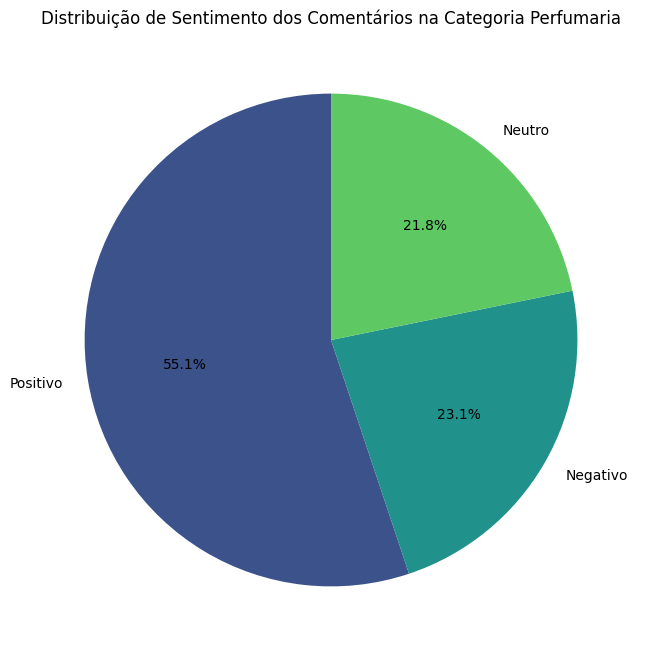

In [ ]:
sentiment_counts = df_comentarios['sentimento_label'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(sentiment_counts)))
plt.title('Distribuição de Sentimento dos Comentários na Categoria Perfumaria')
plt.show()

~55% Positivos: Pouco mais da metade dos clientes teve uma experiência positiva.

~23% Negativos e ~21% Neutros: Um bloco preocupante de quase 40% dos clientes estava ou ativamente insatisfeito ou indiferente.

Isso provou que havia um problema. Mas qual?

#Mergulho Profundo: Foco nos Comentários Negativos

Para encontrar o "gap", decidi focar onde a dor era mais clara. Foi criado um novo DataFrame contendo apenas os comentários classificados como negativos.

O objetivo era extrair os temas mais comuns dessas reclamações.

In [ ]:
df_negativos = df_comentarios[df_comentarios['sentimento_label'] == 'Negativo']

In [ ]:
df_negativos['review_score'].value_counts().sort_index()

,count
review_score,
1,164
2,30
3,34
4,20
5,38


In [ ]:
df_negativos = df_negativos[df_negativos['review_score'] < 5]

In [ ]:
df_negativos.head()

,order_id,product_category_name,review_score,comentario,sentimento_scores,sentimento_compound,sentimento_label
1,000aed2e25dbad2f9ddb70584c5a2ded,perfumaria,1,Mudo minha opinião assim que receber o produto...,"{'neg': 0.149, 'neu': 0.851, 'pos': 0.0, 'comp...",-0.4215,Negativo
10,0094bd07f49fed90209ffa62d1ef26d6,perfumaria,1,Comprei o rímel tango de embalagem vermelha e ...,"{'neg': 0.071, 'neu': 0.929, 'pos': 0.0, 'comp...",-0.1531,Negativo
26,015f079801c424fda3edc48be99267de,perfumaria,1,Ainda nao recebi o produto e ja se encontra at...,"{'neg': 0.417, 'neu': 0.583, 'pos': 0.0, 'comp...",-0.5106,Negativo
37,02440f65dc09737b491463739c347446,perfumaria,1,nao recebi o produto,"{'neg': 0.524, 'neu': 0.476, 'pos': 0.0, 'comp...",-0.2960,Negativo
66,04626f2c41e6a49d4c2102a7d410797a,perfumaria,1,É com muita tristeza que venho realizar essa a...,"{'neg': 0.213, 'neu': 0.718, 'pos': 0.069, 'co...",-0.7003,Negativo


O texto foi normalizado (minúsculas e remoção de pontuação).

Removemos stopwords (palavras comuns como 'o', 'e', 'que', 'para') que não carregam significado.

Coloquei a excessão do "não" pois é uma palavra que esta diretamente ligada com a raiz do problema.

In [ ]:
# Precisamos limpar o texto antes de analisar (remover stopwords, pontuação, etc.)
stop_words_pt = stopwords.words('portuguese')
stop_words_pt.remove('não')

In [ ]:
def limpar_texto(texto):
    texto = texto.lower() # Converte para minúsculo
    texto = re.sub(r'[^\w\s]', '', texto) # Remove pontuação
    # Remove stopwords
    texto_limpo = ' '.join([palavra for palavra in texto.split() if palavra not in stop_words_pt])
    return texto_limpo

In [ ]:
df_negativos['comentario_limpo'] = df_negativos['comentario'].apply(limpar_texto)

In [ ]:
df_negativos.head(10)

,order_id,product_category_name,review_score,comentario,sentimento_scores,sentimento_compound,sentimento_label,comentario_limpo
1,000aed2e25dbad2f9ddb70584c5a2ded,perfumaria,1,Mudo minha opinião assim que receber o produto...,"{'neg': 0.149, 'neu': 0.851, 'pos': 0.0, 'comp...",-0.4215,Negativo,mudo opinião assim receber produto consta site...
10,0094bd07f49fed90209ffa62d1ef26d6,perfumaria,1,Comprei o rímel tango de embalagem vermelha e ...,"{'neg': 0.071, 'neu': 0.929, 'pos': 0.0, 'comp...",-0.1531,Negativo,comprei rímel tango embalagem vermelha recebi ...
26,015f079801c424fda3edc48be99267de,perfumaria,1,Ainda nao recebi o produto e ja se encontra at...,"{'neg': 0.417, 'neu': 0.583, 'pos': 0.0, 'comp...",-0.5106,Negativo,ainda nao recebi produto ja encontra atrasado
37,02440f65dc09737b491463739c347446,perfumaria,1,nao recebi o produto,"{'neg': 0.524, 'neu': 0.476, 'pos': 0.0, 'comp...",-0.2960,Negativo,nao recebi produto
66,04626f2c41e6a49d4c2102a7d410797a,perfumaria,1,É com muita tristeza que venho realizar essa a...,"{'neg': 0.213, 'neu': 0.718, 'pos': 0.069, 'co...",-0.7003,Negativo,muita tristeza venho realizar avaliação fato m...
68,04767604594dae9050fbaf22bca08e6e,perfumaria,1,"negativa enviaram produto errado, nao comprem ...","{'neg': 0.412, 'neu': 0.588, 'pos': 0.0, 'comp...",-0.8446,Negativo,negativa enviaram produto errado nao comprem n...
71,04d545b51bf8586200b03f1e22db97e2,perfumaria,3,"fixação média, mas bons para o cotidiano","{'neg': 0.275, 'neu': 0.725, 'pos': 0.0, 'comp...",-0.2263,Negativo,fixação média bons cotidiano
87,065881aa6f8059a970c8fd9947f717e4,perfumaria,1,Gastei com o frete de 15 reais! É gastei també...,"{'neg': 0.185, 'neu': 0.815, 'pos': 0.0, 'comp...",-0.4753,Negativo,gastei frete 15 reais gastei ir buscar mercado...
89,0662642f8ec31225fd369ca4026cb610,perfumaria,1,"O pincel chegou quebrado, não fiquei satisfeit...","{'neg': 0.469, 'neu': 0.531, 'pos': 0.0, 'comp...",-0.6486,Negativo,pincel chegou quebrado não fiquei satisfeita m...
126,0904fb2c91a18099a0b7315f1ac9501b,perfumaria,1,"O produto além de não ser entregue, não consta...","{'neg': 0.353, 'neu': 0.647, 'pos': 0.0, 'comp...",-0.6124,Negativo,produto além não entregue não consta nenhuma d...


In [ ]:
# 4. Extrair os N-gramas (Bigramas e Trigramas)
# "Pontos de reclamação" raramente são uma palavra só (unigrama).
# Eles são geralmente bigramas (ex: "entrega atrasada") ou trigramas (ex: "produto veio quebrado").
# Extrair os 20 mais comuns.
# (min_df=2 ignora termos que aparecem em menos de 2 comentários)

vectorizer = CountVectorizer(ngram_range=(2, 3), min_df=2)
X = vectorizer.fit_transform(df_negativos['comentario_limpo'])

In [ ]:
soma_termos = X.sum(axis=0)
termos_freq = [(termo, soma_termos[0, idx]) for termo, idx in vectorizer.vocabulary_.items()]
termos_freq_ordenados = sorted(termos_freq, key = lambda x: x[1], reverse=True)

A hipótese inicial era que as reclamações seriam sobre os produtos em si: "fragrância fraca", "fixação ruim", "embalagem quebrada".

No entanto, ao extrair e plotar os termos mais frequentes (usando Bigramas e Trigramas, que capturam frases como "entrega atrasada"), a realidade foi surpreendente.

In [ ]:
print("\n--- Principais Pontos de Reclamação (Bigramas e Trigramas) ---")
print(termos_freq_ordenados[:20])


--- Principais Pontos de Reclamação (Bigramas e Trigramas) ---
[('não recebi', np.int64(50)), ('recebi produto', np.int64(34)), ('não recebi produto', np.int64(25)), ('ainda não', np.int64(22)), ('produto não', np.int64(18)), ('ainda não recebi', np.int64(17)), ('não entregue', np.int64(13)), ('perfume não', np.int64(12)), ('não chegou', np.int64(11)), ('nao recebi', np.int64(9)), ('produto veio', np.int64(8)), ('nao recebi produto', np.int64(7)), ('prazo entrega', np.int64(7)), ('comprei produto', np.int64(6)), ('produto não entregue', np.int64(6)), ('ainda nao', np.int64(5)), ('dinheiro volta', np.int64(5)), ('agora não', np.int64(5)), ('produto não chegou', np.int64(5)), ('não recomendo', np.int64(5))]


/tmp/ipython-input-800581507.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequência', y='Termo', data=df_termos_freq, palette='viridis')


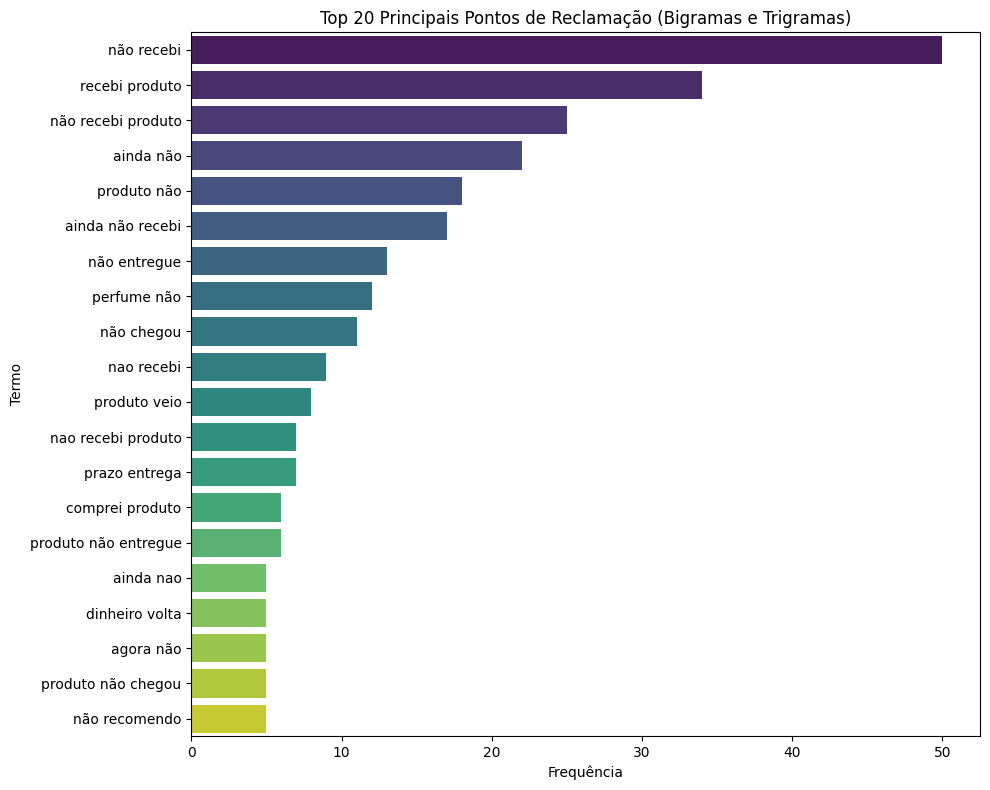

In [ ]:
df_termos_freq = pd.DataFrame(termos_freq_ordenados[:20], columns=['Termo', 'Frequência'])

plt.figure(figsize=(10, 8))
sns.barplot(x='Frequência', y='Termo', data=df_termos_freq, palette='viridis')
plt.title('Top 20 Principais Pontos de Reclamação (Bigramas e Trigramas)')
plt.xlabel('Frequência')
plt.ylabel('Termo')
plt.tight_layout()
plt.show()

Os termos mais repetidos não tinham nada a ver com o produto. Quase 100% das reclamações mais frequentes apontavam para um único culpado: LOGÍSTICA.

Os principais temas foram:

"entrega atrasada"

"não recebi / produto não recebido"

"prazo de entrega"

"demora para entregar"

#Conclusão

A fragrância do Problema era Logístico.

A percepção negativa da categoria "Perfumaria" não estava sendo causada pelos perfumes, mas pela experiência de compra. Os clientes nem sequer tinham a chance de avaliar a fragrância, pois sua frustração estava focada na demora ou na falha total da entrega.

Recomendação Estratégica: A ação de maior impacto para melhorar a performance da categoria não é rever o catálogo de produtos ou fornecedores. A urgência está em uma auditoria e otimização dos processos logísticos (prazo, rastreio, transportadora) associados a esta categoria de produtos.